Datasets used: 

- https://archive.ics.uci.edu/ml/datasets/Abalone

- https://archive.ics.uci.edu/ml/datasets/Iris 

- https://archive.ics.uci.edu/ml/datasets/Adult

# Grade 4

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score

np.random.seed(42)

## Read Data

In [3]:
iris_data = pd.read_csv("iris.csv")
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
abalone_data = pd.read_csv("abalone.csv")
abalone_data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Since we could not find a dataset which met all the asked-for criteria (at least 1000 samples, at least 6 numerical features with at least one having missing values and at least 20% of features being categorical) we decided to use the Adult dataset since it met all the criteria except the missing values in the numerical features which is why we will introduce some artificial missingness into the data.

In [5]:

def preprocess_adult_df(df):
    df = df.replace(" ?", np.nan)
    df = df.drop("education", axis=1)
    for col in ['age', 'hours-per-week']:
        df.loc[df.sample(frac=0.1).index, col] = np.nan
    return df

In [6]:
adult_train_data = pd.read_csv("adult.csv")
adult_train_data = preprocess_adult_df(adult_train_data)
adult_train_data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39.0,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K


In [7]:
adult_test_data = pd.read_csv("adult_test.csv")
adult_test_data = preprocess_adult_df(adult_test_data)
adult_test_data["class"] = adult_test_data["class"].replace("\.", "", regex=True)
adult_data = pd.concat([adult_train_data, adult_test_data], axis=0)
adult_data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39.0,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K


In [8]:
def get_characteristics(df):
    """ Prints all the necessary characteristics of a dataframe."""
    # General characteristics
    print("General characteristics:")
    print(df.info())
    print(df.describe())
    print("\n")

    # Missing value structure
    print("Missing value structure:")
    print(df.isnull().sum())
    print("\n")

    # Correlation between numerical features
    print("Correlation between numerical features:")
    print(df.corr())
    print("\n")

    # Per feature mention: Number of unique values, number of total values, most common values, feature ranges
    for col in df.columns:
        print(f"Feature: {col}")
        print(f"Number of unique values: {df[col].nunique()}")
        print(f"Number of total values: {df[col].count()}")
        print(f"Most common values:")
        print(df[col].value_counts().head())
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            print(f"Feature range: {df[col].min()} to {df[col].max()}")
        print("\n")

## Characteristics Iris Data

In [9]:
get_characteristics(iris_data)

General characteristics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000 

/tmp/ipykernel_12687/606347974.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


General characteristics:
The iris dataset contains 150 observations with 5 columns: sepal length, sepal width, petal length, petal width, and species. The goal is typically to classify the species based on the four numerical features.

Missing value structure:
There are no missing values in the iris dataset.

Correlation between numerical features:
The strongest correlation is between petal length and petal width, with a correlation coefficient of 0,96. Sepal length and sepal width have a weaker negative correlation (-0,11).

## Characteristics Abalone Data

In [10]:
get_characteristics(abalone_data)

General characteristics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole weight    4177 non-null   float64
 5   shucked weight  4177 non-null   float64
 6   viscera weight  4177 non-null   float64
 7   shell weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None
            length     diameter       height  whole weight  shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221

/tmp/ipykernel_12687/606347974.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


General characteristics: The dataset contains 4177 rows and 9 columns. There are 8 numerical features and 1 categorical feature ('sex'). The average age of abalone in the dataset is around 9 years, with the youngest being less than a year old and the oldest being almost 29 years old.

Missing value structure: There are no missing values in the dataset.

Correlation between numerical features: The strongest positive correlation is between 'length' and 'diameter', which is expected since these two features are highly related.

## Characteristics Adult Data

In [11]:
get_characteristics(adult_data)

General characteristics:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             43958 non-null  float64
 1   workclass       46043 non-null  object 
 2   fnlwgt          48842 non-null  int64  
 3   education-num   48842 non-null  int64  
 4   marital-status  48842 non-null  object 
 5   occupation      46033 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   capital-gain    48842 non-null  int64  
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  43958 non-null  float64
 12  native-country  47985 non-null  object 
 13  class           48842 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 5.6+ MB
None
                age        fnlwgt  education-num  capital-gain  capital-loss  \

/tmp/ipykernel_12687/606347974.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


General characteristics: The dataset contains 48,842 rows and 15 columns.
The target variable is the income category, with two possible values: <=50K and >50K.
The dataset contains a mix of categorical and numerical features.
The mean age of the population is 38.58 years, with a standard deviation of 13.64 years.


Missing value structure: There are missing values in three columns: "workclass", "occupation" and "native-country".
The "workclass" column has 2799 missing values, while the "occupation" column has 2809 missing values and the "native-country" column has 857 missing values. We introduced 10% missing data for the "age" and "hours-per-week" features resulting in 4884 missing values respectively.


Correlation between numerical features: The numerical features ("age", "fnlwgt", "education-num", "capital-gain", and "capital-loss") do not appear to be strongly correlated with each other, with correlation coefficients ranging from -0.08 to 0,14.

# Grade 3

In [12]:
def get_numerical_features(data: pd.DataFrame):
    # select only numerical features and use subset of minimum 1000 samples
    return pd.DataFrame(data.select_dtypes(np.number))

# gets the k nearest neighbours of a single data point
# data_point is the row index
def get_k_nn(data: np.ndarray, data_point_index: int, k: int):
    assert 0 <= data_point_index < data.shape[0] and k > 0

    # distances = squareform(pdist(data))[data_point_index]
    data_point = data[data_point_index]
    diff = data - data_point

    distances = np.linalg.norm(diff, axis=1)

    # get the smallest distance indices
    # drop first distance because this is the distance to the same point
    index_mask = np.argsort(distances)[1:k+1]

    return distances[index_mask], index_mask

def get_precision_score(data: pd.DataFrame, neighbour_index_mask, data_point_index, target_feature_name, k):
    nearest_neighbours = data.iloc[neighbour_index_mask]
    target_of_datapoint = data.iloc[data_point_index][target_feature_name]

    return len(nearest_neighbours[nearest_neighbours[target_feature_name]==target_of_datapoint]) / k

In [13]:
# remove missing values from adult dataset

print(f"adult shape with missing values: {adult_data.shape}")

adult_data = adult_data.dropna()

print(f"adult shape without missing values: {adult_data.shape}")

adult shape with missing values: (48842, 14)
adult shape without missing values: (36651, 14)


We couldn't find any datasets that fulfil the requirements for this assignment, so we introduced missing values by hand as a preprocessing step of the adult dataset. 

We dropped all the samples that contained missing values. Another way would be to calculate the mean of the feature where missing values occur and fill them in.

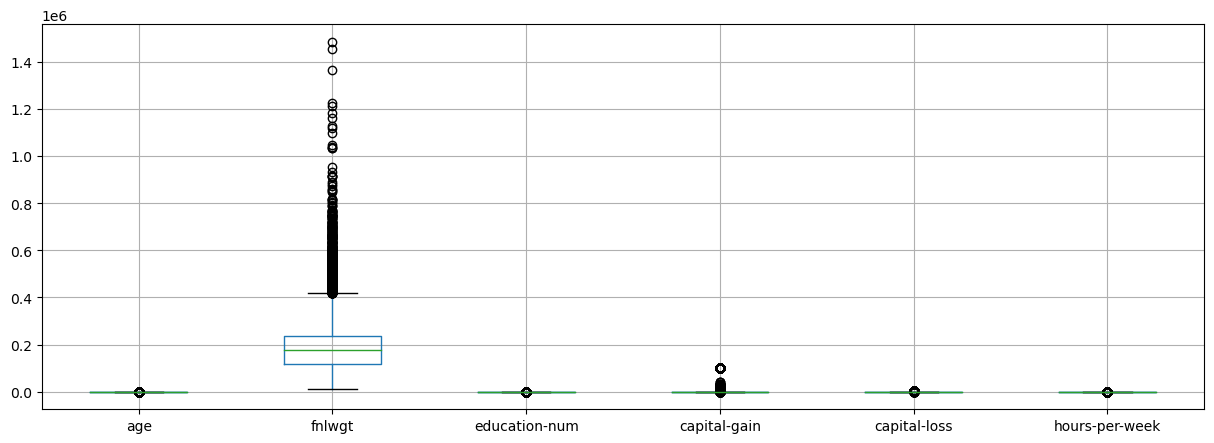

In [14]:
plt.figure(figsize=(15, 5))
adult_data.boxplot()
plt.show()

In [15]:
# use adult dataset for the next tasks and generate a subset of 1000 samples

adult_data_subset = adult_data.iloc[:1000]

numerical_data = get_numerical_features(adult_data_subset)
print(numerical_data.shape)

columns = numerical_data.columns

# now use standard scaling on the numerical features
numerical_data = pd.DataFrame(StandardScaler().fit_transform(numerical_data), columns=columns)

(1000, 6)


Standard scaling, or more generally, every scaling affects the precision score. For example, if features are not scaled, the feature with the biggest magnitude affects distances the most, and hence, the neighbours and the corresponding precision scores are more biased toward that feature. 

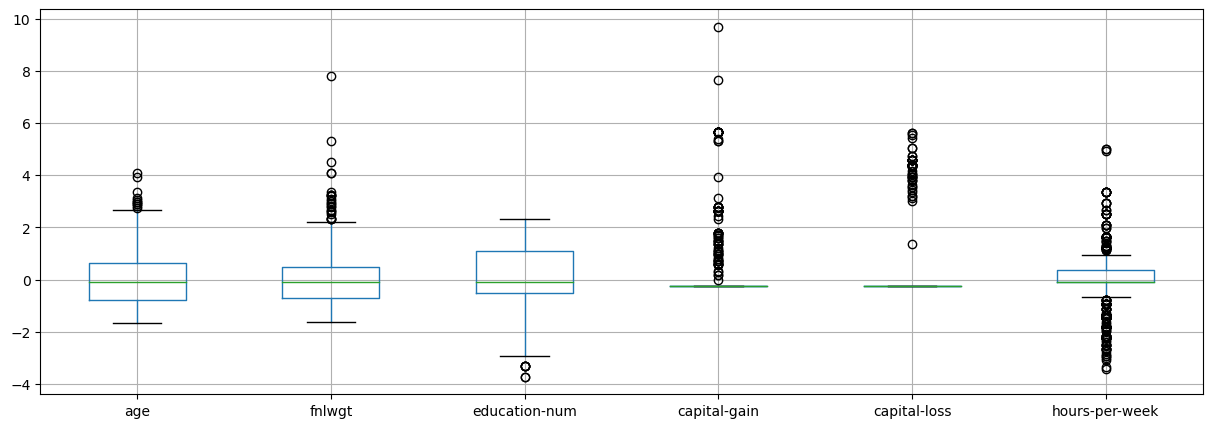

In [16]:
plt.figure(figsize=(15, 5))
numerical_data.boxplot()
plt.show()

There exist some methods to determine outliers. For Example, z-score, interquartile range or a boxplot for a visual representation. The following code block with a z-score threshold of 3. This method filters outliers that are far from the mean in terms of standard deviation. In our example, we only used numerical features for determining outliers. 

In [17]:
# the following code returns the indices of data points that are classified as outliers

z_scores = np.abs(stats.zscore(numerical_data))
outlier_indices = np.where(z_scores > 3)
outlier_indices = np.unique(np.concatenate(outlier_indices))
print(outlier_indices)

[  0   1   2   3   4   5   7   9  20  26  30  41  67  78  87 100 104 116
 120 127 139 141 150 156 161 165 170 174 179 183 196 199 216 223 235 249
 253 257 282 298 304 315 316 323 324 326 334 338 358 362 376 391 393 398
 411 413 452 453 458 479 490 500 511 514 528 542 556 564 601 612 614 634
 636 670 697 698 700 708 710 713 714 723 737 749 758 766 772 776 790 795
 802 808 814 816 821 823 826 844 871 877 883 893 894 897 926 936 950 952
 962 967 971 974 976]


In [18]:
def average_precision_score(orignal_data, numerical_data, k):
    precision_scores = []

    for data_point in range(numerical_data.shape[0]):
        distances, nearest_neighbours = get_k_nn(numerical_data.to_numpy(), data_point, k)
        precision_scores.append(get_precision_score(orignal_data, nearest_neighbours, data_point, "class", k))
        break

    return np.average(precision_scores)

In [19]:
scores = []
dimensions = range(1, numerical_data.shape[1] + 1)

k = 10

for d in dimensions:
    selected_features = numerical_data.sample(n=d, axis=1, random_state=42) # randomly select n features

    score = average_precision_score(adult_data_subset, selected_features, k)
    scores.append(score)

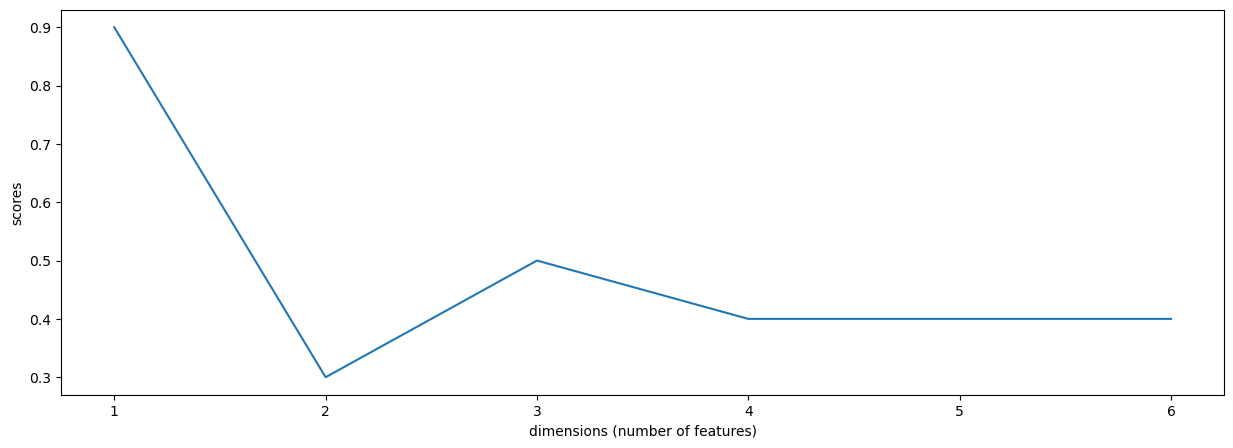

In [20]:
plt.figure(figsize=(15,5))
sns.lineplot(x=dimensions, y=scores)
plt.xlabel("dimensions (number of features)")
plt.ylabel("scores")
plt.show()

The line chart above shows the score for different numbers of features using k = 10. In our case, it seems that increasing the dimensionality decreases the score. However, since our dataset (adult) only consists of 6 numerical features, this does not very informative.

# Grade 2

## a)

In [21]:
def plot_hists(df, target_col=None):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    if target_col:
        # Loop through each numeric column in the dataset
        for col in numeric_cols:
            # Create a histogram for the column using matplotlib
            sns.histplot(data=df, x=col, hue=target_col, multiple='stack', bins=25)
            plt.title(col)
            plt.show()
    else:
        # Loop through each numeric column in the dataset
        for col in numeric_cols:
            # Create a histogram for the column using matplotlib
            plt.hist(df[col], bins=25)
            plt.title(col)
            plt.show()

In [22]:
def chi_squared_test(df, categorical_vars):
    # Apply the Chi-Squared test of independence pairwise to categorical variables
    results = []
    for i, var1 in enumerate(categorical_vars):
        for var2 in categorical_vars[i+1:]:
            contingency_table = pd.crosstab(df[var1], df[var2]).values
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            results.append((var1, var2, p))

    # Print the results
    for result in results:
        print(result)

### Iris

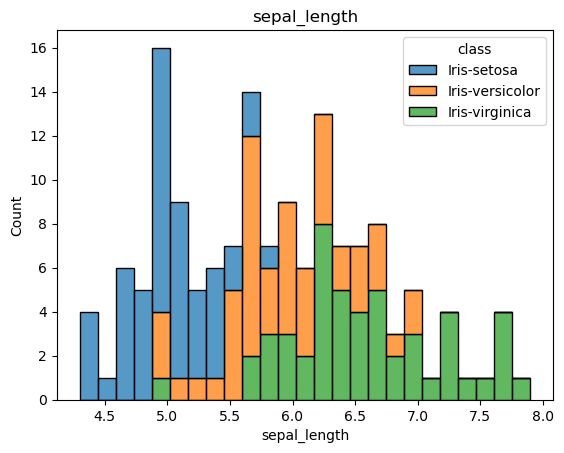

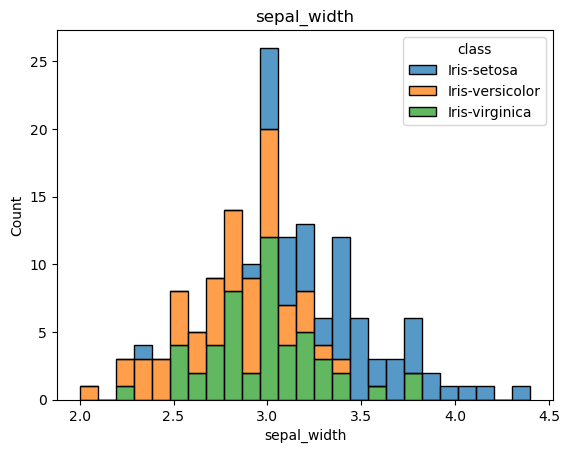

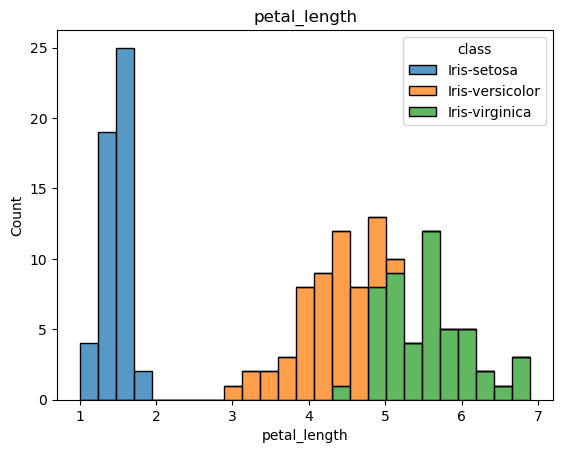

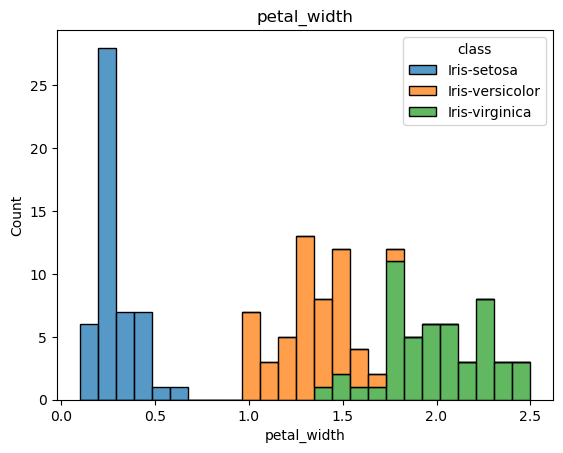

In [23]:
plot_hists(iris_data, "class")

As we can see sepal_width closely resembles a bell curve with sepal_length approximating a bell curve more roughly. petal_length and petal_width seem to both have spikes on the lower end of the spectrum while the upper end more or less resembles bell curves indicating a multi-modal structure in both of them. We can also spot a slight multi-modal structure in the sepal_length.

As we can see there are clearly tendencies of the iris-setosa to be on the lower end of the petal_length, petal_width and sepal_length spectra while iris-versicolor seems to be in the middle parts sometimes overlapping with iris-virginica which is mostly on the upper part of the spectra.

There are no categorical features in the iris dataset.

### Abalone

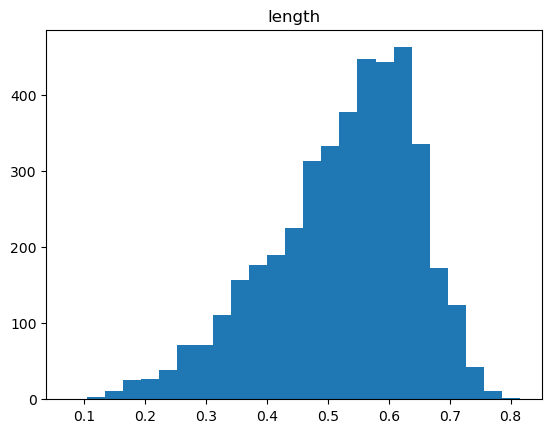

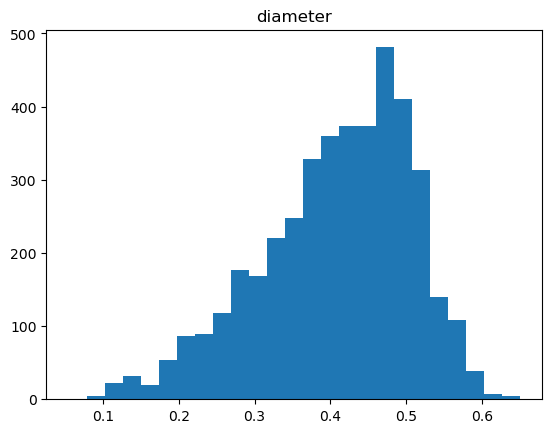

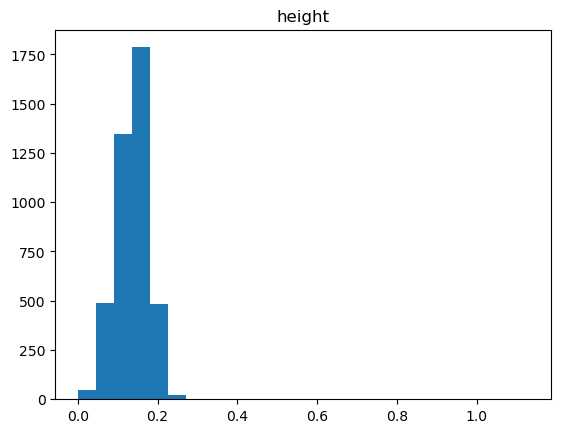

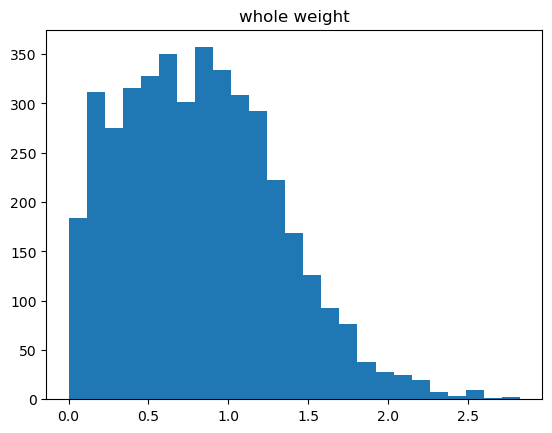

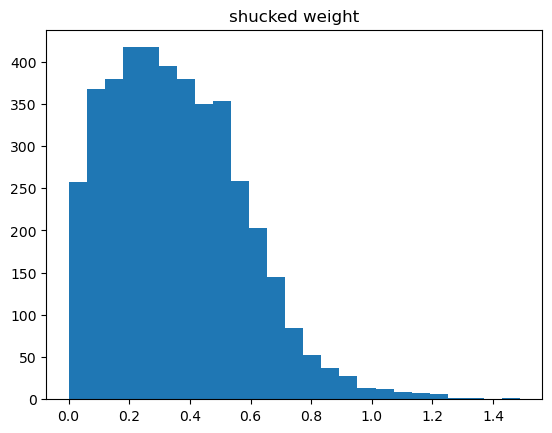

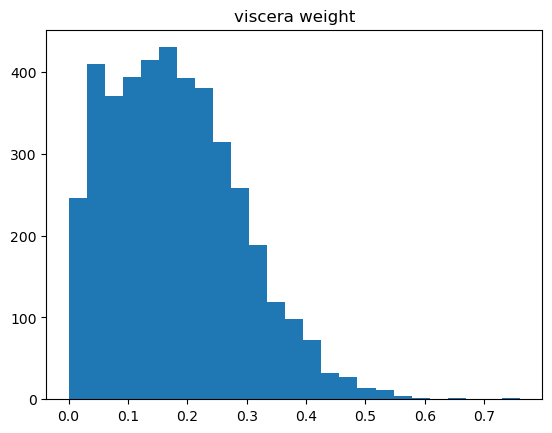

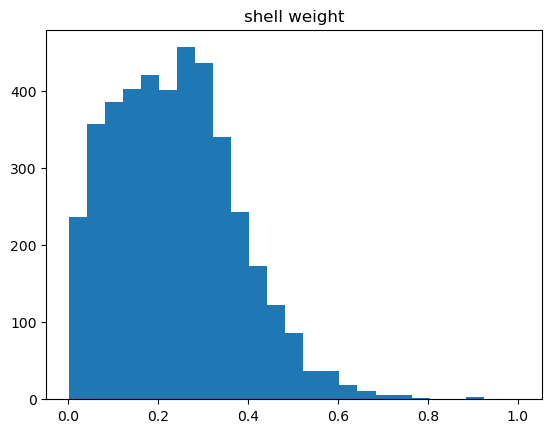

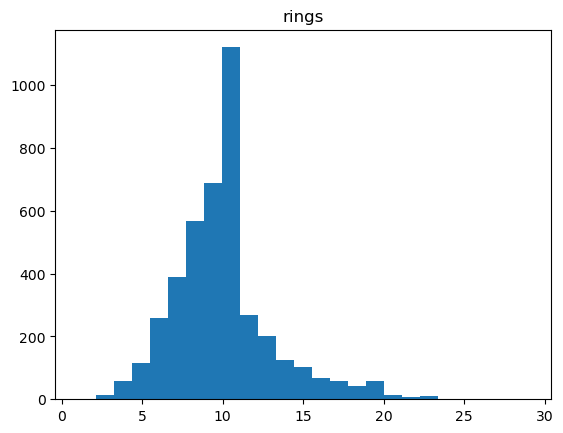

In [24]:
plot_hists(abalone_data)

We see a general tendency towards bell curves in all of the features. Some more shifted to the left of the spectrum (e.g. height and weights) and some more to the right (e.g. length and diameter). There don't seem to be any multi-modal structures present.

There is only one feature that we could treat as categorical ("sex") so we can not perform the pairwise comparison.

### Adult

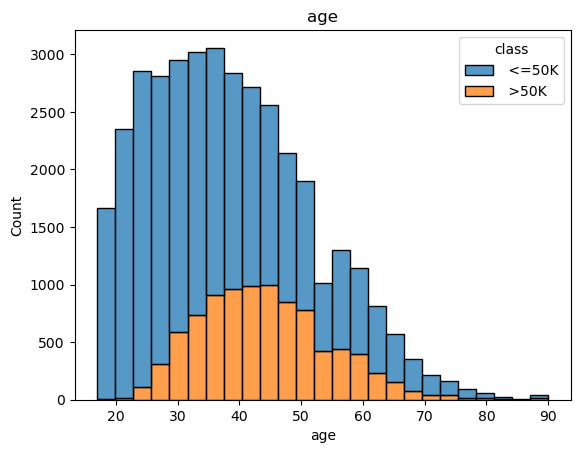

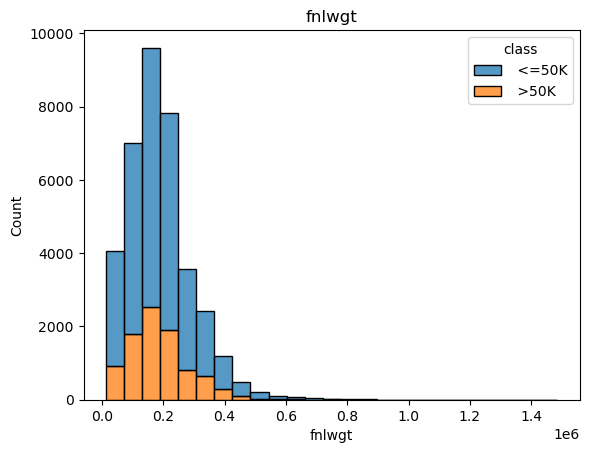

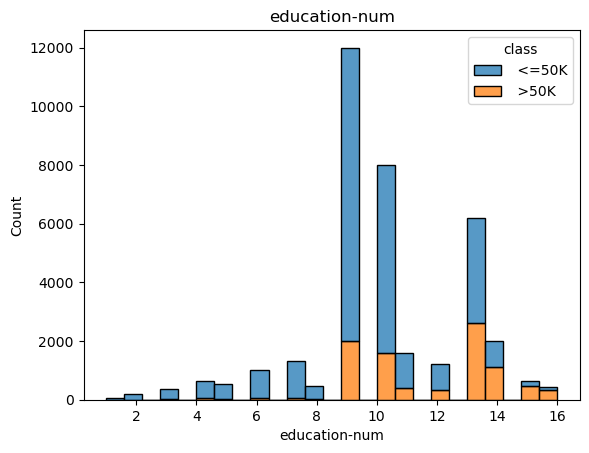

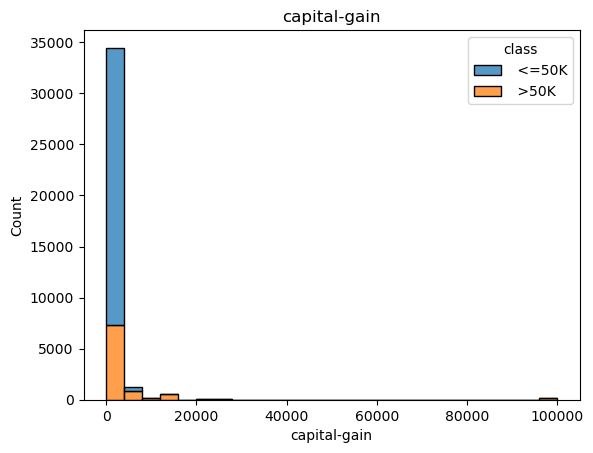

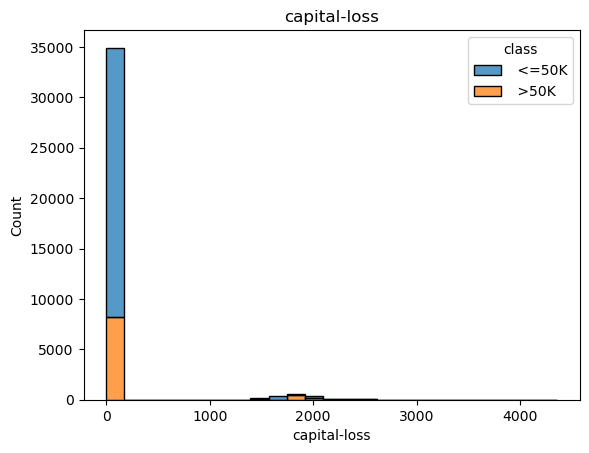

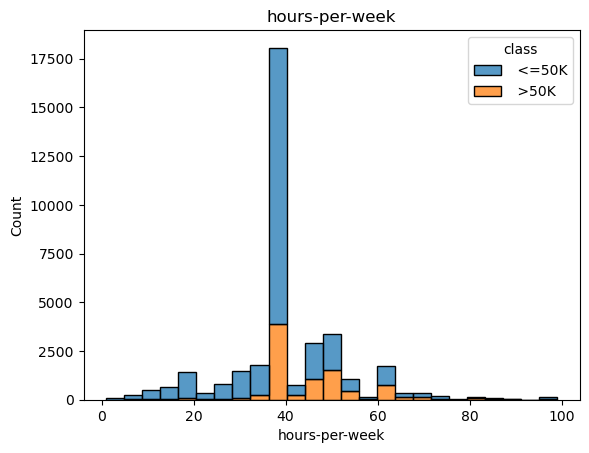

In [25]:
plot_hists(adult_data, "class")

There do not seem to be any multi-modal structures that correlate with the class labels but there are a lot of values being 0 for capital-loss and capital-gain which stem from the nature of the data in that not as many people are likely to invest money.

In [26]:
# Before running the chi-squared-test we need to remove any rows with missing values in one of the categorical features
non_missing_adult_data = adult_data.dropna(subset=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])
chi_squared_test(non_missing_adult_data, ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

('workclass', 'marital-status', 1.5005373630433975e-258)
('workclass', 'occupation', 0.0)
('workclass', 'relationship', 1.5911697628585018e-287)
('workclass', 'race', 6.145121627257771e-99)
('workclass', 'sex', 1.0235101712348582e-161)
('workclass', 'native-country', 1.0753267655762338e-28)
('marital-status', 'occupation', 0.0)
('marital-status', 'relationship', 0.0)
('marital-status', 'race', 1.4319692532331355e-194)
('marital-status', 'sex', 0.0)
('marital-status', 'native-country', 2.4207580470777377e-117)
('occupation', 'relationship', 0.0)
('occupation', 'race', 5.560286464588953e-171)
('occupation', 'sex', 0.0)
('occupation', 'native-country', 3.6187137541262745e-271)
('relationship', 'race', 9.05343558783205e-275)
('relationship', 'sex', 0.0)
('relationship', 'native-country', 4.7345870385544615e-141)
('race', 'sex', 6.89922196242661e-110)
('race', 'native-country', 0.0)
('sex', 'native-country', 9.761535472284243e-14)


Looking at the results, we can see that most of the pairwise p-values are very small (e.g., 0.0 or 1e-200), indicating that the null hypothesis is rejected and the variables are not independent. For example, the pair ('workclass', 'occupation') has a p-value of 0.0, which means that we reject the null hypothesis that the two variables are independent.

Some of the pairs have larger p-values but are still very small (e.g., 1e-14). For example, the pair ('sex', 'native-country') has a p-value of 9.76e-14, which is small enough to reject the null hypothesis.

In general, the results suggest that there are strong associations between many pairs of categorical variables in the Adult dataset and that these associations are unlikely to have occurred by chance. The pairs with the smallest p-values are the most strongly associated and may be of particular interest for further investigation.

## b)

In [27]:
adult_train_no_missing = adult_train_data.dropna()
adult_test_no_missing = adult_test_data.dropna()

adult_train_num = adult_train_no_missing.select_dtypes(include=['int', 'float'])
adult_test_num = adult_test_no_missing.select_dtypes(include=['int', 'float'])

X_train = adult_train_num.to_numpy()
X_test = adult_test_num.to_numpy()
y_train = adult_train_no_missing["class"].to_numpy()
y_test = adult_test_no_missing["class"].to_numpy()

# Apply standard scaling to the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_describe = pd.DataFrame(X_train_scaled)
df_describe.describe()



,0,1,2,3,4,5
count,2.445400e+04,2.445400e+04,2.445400e+04,2.445400e+04,2.445400e+04,2.445400e+04
mean,-1.380174e-16,1.313345e-16,-3.050911e-16,-4.213163e-18,1.743378e-17,-9.733860e-17
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-1.629037e+00,-1.666008e+00,-3.576715e+00,-1.469381e-01,-2.171669e-01,-3.329800e+00
25%,-7.927769e-01,-6.851018e-01,-4.420360e-01,-1.469381e-01,-2.171669e-01,-7.759280e-02
50%,-1.085639e-01,-1.064039e-01,-5.020113e-02,-1.469381e-01,-2.171669e-01,-7.759280e-02
75%,6.516727e-01,4.544924e-01,1.125303e+00,-1.469381e-01,-2.171669e-01,3.393568e-01
max,3.920690e+00,1.232055e+01,2.300808e+00,1.311359e+01,1.067216e+01,4.842413e+00


In [28]:
# Apply whitening transformation to the training data
pca = PCA(whiten=True)
X_train_whitened = pca.fit_transform(X_train)
X_test_whitened = pca.transform(X_test)
df_describe = pd.DataFrame(X_train_whitened)
df_describe.describe()


,0,1,2,3,4,5
count,2.445400e+04,2.445400e+04,2.445400e+04,2.445400e+04,2.445400e+04,2.445400e+04
mean,1.313345e-16,-9.879142e-18,1.293005e-17,-1.429570e-16,-1.888659e-17,2.930328e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.665976e+00,-1.725039e-01,-2.333162e-01,-2.731090e+00,-4.547244e+00,-2.835566e+00
25%,-6.850848e-01,-1.477181e-01,-2.260452e-01,-7.085859e-01,-4.854604e-01,-8.115029e-01
50%,-1.064032e-01,-1.465654e-01,-2.218122e-01,-1.702321e-02,3.006479e-02,9.582182e-02
75%,4.544816e-01,-1.451917e-01,-2.153483e-01,7.045891e-01,4.648435e-01,4.438876e-01
max,1.232030e+01,1.311659e+01,1.066928e+01,5.258932e+00,5.234881e+00,4.067649e+00


In [29]:
# Compute the nearest neighbors for the scaled data
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train)
y_pred = knn_scaled.predict(X_test_scaled)
score_scaled = precision_score(y_test, y_pred, average='weighted')

# Compute the nearest neighbors for the whitened data
knn_whitened = KNeighborsClassifier()
knn_whitened.fit(X_train_whitened, y_train)
y_pred = knn_whitened.predict(X_test_whitened)
score_whitened = precision_score(y_test, y_pred, average='weighted')

# Compute the nearest neighbors for the raw data
knn_raw = KNeighborsClassifier()
knn_raw.fit(X_train, y_train)
y_pred = knn_raw.predict(X_test)
score_raw = precision_score(y_test, y_pred, average='weighted')

# Compare the scores
print("Standard scaling score:", score_scaled)
print("Whitening score:", score_whitened)
print("Raw score:", score_raw)

Standard scaling score: 0.7795689557944576
Whitening score: 0.7796328332955828
Raw score: 0.737392809328682


In [30]:
# Compute correlation matrix
corr_matrix = adult_train_num.corr()

# Print correlation matrix
print(corr_matrix)

                     age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.077463       0.040931      0.080146      0.061872   
fnlwgt         -0.077463  1.000000      -0.041834      0.002066     -0.006888   
education-num   0.040931 -0.041834       1.000000      0.125336      0.079847   
capital-gain    0.080146  0.002066       0.125336      1.000000     -0.031910   
capital-loss    0.061872 -0.006888       0.079847     -0.031910      1.000000   
hours-per-week  0.105507 -0.019258       0.153331      0.081851      0.050739   

                hours-per-week  
age                   0.105507  
fnlwgt               -0.019258  
education-num         0.153331  
capital-gain          0.081851  
capital-loss          0.050739  
hours-per-week        1.000000  


As we can see while both whitening and standard scaling improve the score the scores don't differ much. Since the main difference between Standard Scaling and Whitening Transform is that Standard Scaling simply scales each feature so that they have zero mean and unit variance, while Whitening Transform additionally removes any correlation between features we can conclude that there is not a strong correlation between any of the numerical features which lead to no improvement using the whitening.

## c)

In [31]:
# Define range of neighbors k
k_range = range(1, 11)

# Create empty list to store precision scores for each k
precision_scores = []

# Loop through k_range and fit K-NN model for each k value
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))

# Print precision scores for each k
print("Precision Scores for k =", list(k_range))
print(precision_scores)

Precision Scores for k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.756657100753142, 0.7779487495771806, 0.7712754751524028, 0.7849954311064645, 0.7795689557944576, 0.7897377902563466, 0.785629642561839, 0.7900441958784425, 0.7885977149219247, 0.7938217548145435]


As we can see the scores are generally rather high independent of the choice of k. We can also see an upward trend in the score when we up k with the highest value achieved at k=10.

# Grade 1

## a)

In [32]:
def get_parameter_grid_for_data(data):
    max_k = 15

    grid_params = {
        "dimension": np.arange(1, data.shape[1] + 1),
        "k": np.arange(1, max_k + 1)
    }

    return list(ParameterGrid(grid_params))

In [33]:
def calc_scores_for_parameter_grid(X_train, X_test, y_train, y_test):
    scores = []

    for params in get_parameter_grid_for_data(X_train):
        d = params["dimension"]
        k = params["k"]
        
        dim_reduced_train = X_train[:, :d]
        dim_reduced_test = X_test[:, :d]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(dim_reduced_train, y_train)
        score = knn.score(dim_reduced_test, y_test)

        scores.append((k, d, score))
    
    return scores

def plot_param_scores(scores, title):
    fig = plt.figure(figsize =(15, 7)) 
    ax = plt.axes(projection ='3d')

    X = np.array([t[0] for t in scores])
    Y = np.array([t[1] for t in scores])
    Z = np.array([t[2] for t in scores])

    # color map from: https://stackoverflow.com/a/47872260
    red_to_green = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

    trisurf = ax.plot_trisurf(X, Y, Z, cmap=red_to_green)

    fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)

    ax.set_xlabel('k', fontweight ='bold')
    ax.set_ylabel('dimension', fontweight ='bold')
    ax.set_zlabel('score', fontweight ='bold')

    plt.title(title)

    plt.show()

    print(f"best params (k, dimension, score) = {sorted(scores, key=lambda t: t[2])[-1]}")

In [34]:
scores = calc_scores_for_parameter_grid(X_train_scaled, X_test_scaled, y_train, y_test)

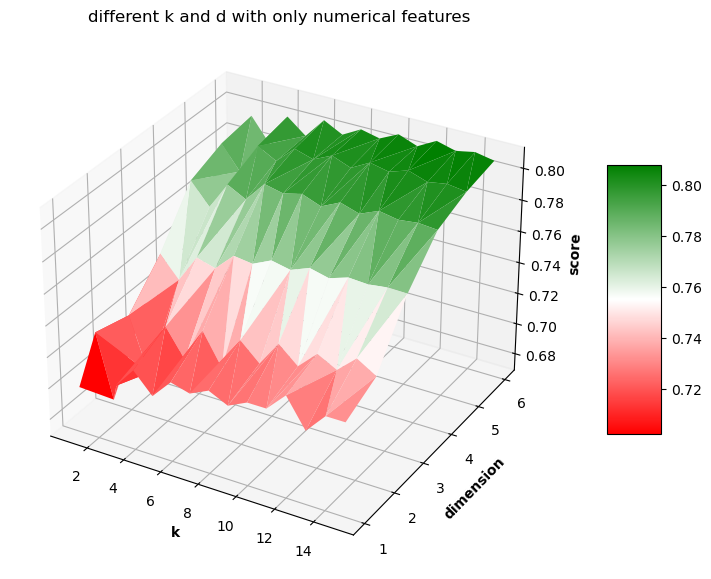

best params (k, dimension, score) = (12, 6, 0.8101992293186849)


In [35]:
plot_param_scores(scores, "different k and d with only numerical features")

According to the 3d plot above, we can see that k and the dimension correlate positively with the score. Furthermore, we can say that at least for our example the correlation between dimension and score is stronger than k and score. We can observe that, by fixing one feature and observing how the other one changes in relation to the score. In that example, this more or less holds for every value of k and the dimension. 

## b)

There are different methods of how categorical features can be integrated into an ML problem. For example, scikit-learn supports three the following three: 

- LabelEncoding: Each label is assigned a value from zero to n-1 different labels

- OneHotEncoding: This method creates a new feature for each label and if a sample matches it, the corresponding value will be set to 1 otherwise 0.

- OrdinalEncoding: If categorical features have some ordering for example grades (bad, neutral, good), this method assigns values from 0 to n-1 with respect to the order.

For simplicity, in our case, we just use label encoding.

In [36]:
# preprocess data to include all features

target_name = ["class"]
categorical_feature_names = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

categorical_features_train = pd.DataFrame()
categorical_features_test = pd.DataFrame()

# iterate through categorical features and encode them
for cfn in categorical_feature_names:
    categorical_features_train[cfn] = LabelEncoder().fit_transform(adult_train_no_missing[cfn])
    categorical_features_test[cfn] = LabelEncoder().fit_transform(adult_test_no_missing[cfn])

scaler = StandardScaler()

# scale numerical features
X_train_num = scaler.fit_transform(adult_train_no_missing.drop(categorical_feature_names + target_name, axis=1))
X_test_num = scaler.fit_transform(adult_test_no_missing.drop(categorical_feature_names + target_name, axis=1))

# add categorical features to data
X_train_full = np.hstack((categorical_features_train, X_train))
X_test_full = np.hstack((categorical_features_test, X_test))

In [37]:
scores_with_categorical = calc_scores_for_parameter_grid(X_train_full, X_test_full, y_train, y_test)

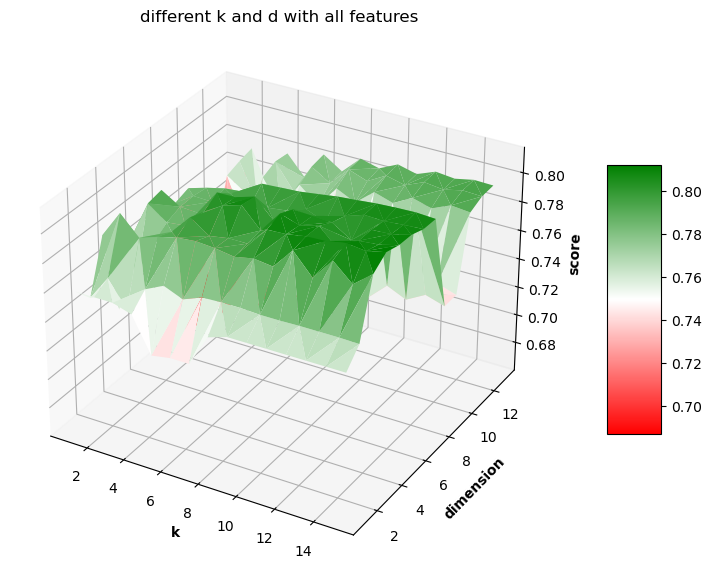

best params (k, dimension, score) = (15, 4, 0.8142166106419612)


In [38]:
plot_param_scores(scores_with_categorical, "different k and d with all features")

Fix the dimension and k ∈ [1, 15]. Then we can again observe that there is a small linear correlation between k and the score. 

However, according to the plot, it seems that we can achieve the best performance when using only four features. Furthermore, we could investigate which features contribute the most to a high score and filter out the other ones to get a better performance